<a href="https://colab.research.google.com/github/ipeirotis/datasets/blob/master/notebooks/DOH_Restaurant_Inspections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www1.nyc.gov/site/doh/business/food-operators/the-inspection-process.page

See https://www1.nyc.gov/assets/doh/downloads/pdf/rii/blue-book.pdf

## Download Latest Dataset

In [1]:
!curl 'https://data.cityofnewyork.us/api/views/43nn-pn8j/rows.csv?accessType=DOWNLOAD' -o restaurants.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 86.3M    0 86.3M    0     0  4908k      0 --:--:--  0:00:18 --:--:-- 5346k


In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv("restaurants.csv", dtype = 'object')

In [3]:
initial_size = len(df)
initial_size

205587

In [4]:
# Render our plots inline
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
df.dtypes

CAMIS                    object
DBA                      object
BORO                     object
BUILDING                 object
STREET                   object
ZIPCODE                  object
PHONE                    object
CUISINE DESCRIPTION      object
INSPECTION DATE          object
ACTION                   object
VIOLATION CODE           object
VIOLATION DESCRIPTION    object
CRITICAL FLAG            object
SCORE                    object
GRADE                    object
GRADE DATE               object
RECORD DATE              object
INSPECTION TYPE          object
Latitude                 object
Longitude                object
Community Board          object
Council District         object
Census Tract             object
BIN                      object
BBL                      object
NTA                      object
Location Point1          object
dtype: object

In [6]:
# Adding underscores in all column names
cols = df.columns
cols = cols.map(lambda x: x.replace(' ', '_').upper())
df.columns = cols

In [7]:
df.dtypes

CAMIS                    object
DBA                      object
BORO                     object
BUILDING                 object
STREET                   object
ZIPCODE                  object
PHONE                    object
CUISINE_DESCRIPTION      object
INSPECTION_DATE          object
ACTION                   object
VIOLATION_CODE           object
VIOLATION_DESCRIPTION    object
CRITICAL_FLAG            object
SCORE                    object
GRADE                    object
GRADE_DATE               object
RECORD_DATE              object
INSPECTION_TYPE          object
LATITUDE                 object
LONGITUDE                object
COMMUNITY_BOARD          object
COUNCIL_DISTRICT         object
CENSUS_TRACT             object
BIN                      object
BBL                      object
NTA                      object
LOCATION_POINT1          object
dtype: object

In [8]:
df.drop('LOCATION_POINT1', axis=1, inplace=True)

## Cleaning Individual Columns

In [9]:
df.CAMIS.isnull().sum()

0

In [10]:
df.DBA.isnull().sum()

454

In [11]:
# Checks that all CAMIS values correpond to a unique DBA value
# ie the same CAMIS always has the same DBA
max_cardinality = df[['DBA','CAMIS']].pivot_table(
    index='CAMIS',
    values='DBA',
    aggfunc=pd.Series.nunique
).DBA.max()

assert(max_cardinality==1)

### INSPECTION_TYPE

In [12]:
df.INSPECTION_TYPE.value_counts()

Cycle Inspection / Initial Inspection                          112967
Cycle Inspection / Re-inspection                                36080
Pre-permit (Operational) / Initial Inspection                   30463
Pre-permit (Operational) / Re-inspection                         9085
Administrative Miscellaneous / Initial Inspection                4756
Pre-permit (Non-operational) / Initial Inspection                2447
Pre-permit (Operational) / Compliance Inspection                 1513
Cycle Inspection / Reopening Inspection                          1415
Administrative Miscellaneous / Re-inspection                      930
Pre-permit (Operational) / Reopening Inspection                   711
Cycle Inspection / Compliance Inspection                          687
Smoke-Free Air Act / Initial Inspection                           549
Trans Fat / Initial Inspection                                    381
Inter-Agency Task Force / Initial Inspection                      341
Calorie Posting / In

In [13]:
sum(df.INSPECTION_TYPE.isnull())

2205

In [14]:
# We create a column "TO_DELETE" to mark the entries that we are not interested in.
# We will perform first the inspection/analysis on all the attributes, and then delete the rows

# Drop all cases where inspection is NULL
df['TO_DELETE'] = df.INSPECTION_TYPE.isnull()

In [15]:
sum(df['TO_DELETE'])

2205

In [16]:
# Break INSPECTION_TYPE into two columns, and also delete some inspection types

# Create a new column that contains the results of the split on the '/'' character
lst = df.INSPECTION_TYPE.str.split(' / ').values.tolist()
lst = [ l if type(l)==type(list()) else ['',''] for l in lst ]
t = pd.DataFrame(lst)


In [17]:
t[0].value_counts()

Cycle Inspection                151169
Pre-permit (Operational)         41975
Administrative Miscellaneous      5825
Pre-permit (Non-operational)      2660
                                  2205
Smoke-Free Air Act                 607
Trans Fat                          445
Calorie Posting                    359
Inter-Agency Task Force            342
Name: 0, dtype: int64

In [18]:
t[1].value_counts()

Initial Inspection              152211
Re-inspection                    46437
Compliance Inspection             2324
                                  2205
Reopening Inspection              2166
Second Compliance Inspection       237
Limited Inspection                   7
Name: 1, dtype: int64

In [19]:
# Keep only cycle inspections. Ignore admin, pre-permit, transfat, and calorie posting inspections
# We will only keep the initial inspections and the re-inspections. The other types are border cases

keep = df.INSPECTION_TYPE.isin( ['Cycle Inspection / Initial Inspection', 'Cycle Inspection / Re-inspection'])


In [20]:
# Check how many we will drop: ~keep means negation on the keep and summing up adds up the 'True'
sum(~keep)

56540

In [21]:
# Adding the "not keep" entries into the TO_DELETE

# The |= operator is a shortcut for df['TO_DELETE'] = df['TO_DELETE'] | ~keep
# We use the bit-OR operator (|), as we want to keep the existing deletions, and add the ones from the
# additional condition
df['TO_DELETE'] |= ~keep

In [22]:
# Rename the two entries that we will keep into simpler values

df["INSPECTION_TYPE"].replace(
    to_replace='Cycle Inspection / Initial Inspection',
    value = 'Initial Inspection',
    inplace=True
)
df["INSPECTION_TYPE"].replace(
    to_replace='Cycle Inspection / Re-inspection',
    value = 'Re-inspection',
    inplace=True
)

In [23]:
sum(df['TO_DELETE'])

56540

### BORO

In [24]:
df.BORO.value_counts()

Manhattan        76160
Brooklyn         54810
Queens           49213
Bronx            18469
Staten Island     6923
0                   12
Name: BORO, dtype: int64

In [25]:
sum(df.BORO.isnull())

0

In [26]:
# Replace the "Missing" in BORO with null
# df.BORO = df.BORO.replace('Missing', np.NaN)

In [27]:
missing = set(df[df.BORO.isnull()].CAMIS)
# missing

In [28]:
sum(df.BORO == '0')

12

In [29]:
# Remove the entries with null/missing BORO value
# Not worth trying to fix.
df['TO_DELETE'] |= (df.BORO == '0')

In [30]:
sum(df['TO_DELETE'])

56540

### BUILDING

In [31]:
sum(df.BUILDING.isnull())

386

In [ ]:
# Inspect the entries with missing street number
# df[df.BUILDING.isnull()]

In [32]:
# Dropping the violations listed without street number
# Most are in train stations and in airports, but there
# are a few others in 'regular' locations

df['TO_DELETE'] |= df.BUILDING.isnull()

In [33]:
sum(df['TO_DELETE'])

56844

### STREET

In [34]:
# Check that no street values are empty
sum(df.STREET.isnull())

4

In [35]:
df['TO_DELETE'] |= df.STREET.isnull()

In [36]:
sum(df['TO_DELETE'])

56844

### ZIPCODE

In [37]:
sum(df.ZIPCODE.isnull())

2705

In [38]:
len(set(df[df.ZIPCODE.isnull()].CAMIS))

414

In [39]:
df['TO_DELETE'] |= df.ZIPCODE.isnull()

In [ ]:
# TODO: Fill in the missing zip codes, perhaps with geocoding of the addresses
# For now, we just drop the cases without ZIPCODE

### CUISINE DESCRIPTION

In [40]:
df.CUISINE_DESCRIPTION.value_counts()

American          34175
Chinese           20239
Coffee/Tea        13487
Pizza             12583
Latin American     8218
                  ...  
Armenian             15
Czech                12
Basque                9
Haute Cuisine         5
Chimichurri           2
Name: CUISINE_DESCRIPTION, Length: 89, dtype: int64

In [41]:
len(df.CUISINE_DESCRIPTION.value_counts())

89

In [42]:
sum(df.CUISINE_DESCRIPTION.isnull())

2205

In [ ]:
'''
df.CUISINE_DESCRIPTION.replace(
    to_replace='Café/Coffee/Tea',
    value = 'Cafe',
    inplace=True
)

df.CUISINE_DESCRIPTION.replace(
    to_replace='Latin (Cuban, Dominican, Puerto Rican, South & Central American)',
    value = 'Latin',
    inplace=True
)
'''

"\ndf.CUISINE_DESCRIPTION.replace(\n    to_replace='Café/Coffee/Tea',\n    value = 'Cafe',\n    inplace=True\n)\n\ndf.CUISINE_DESCRIPTION.replace(\n    to_replace='Latin (Cuban, Dominican, Puerto Rican, South & Central American)',\n    value = 'Latin',\n    inplace=True\n)\n"

### INSPECTION_DATE

In [43]:
df["INSPECTION_DATE"] = pd.to_datetime(df["INSPECTION_DATE"], format="%m/%d/%Y")

In [44]:
df.INSPECTION_DATE.describe(datetime_is_numeric=True)

count                           205587
mean     2020-12-23 13:05:52.335507712
min                1900-01-01 00:00:00
25%                2022-01-05 00:00:00
50%                2022-08-03 00:00:00
75%                2023-02-23 00:00:00
max                2023-09-16 00:00:00
Name: INSPECTION_DATE, dtype: object

In [45]:
sum(df.INSPECTION_DATE.isnull())

0

<Axes: >

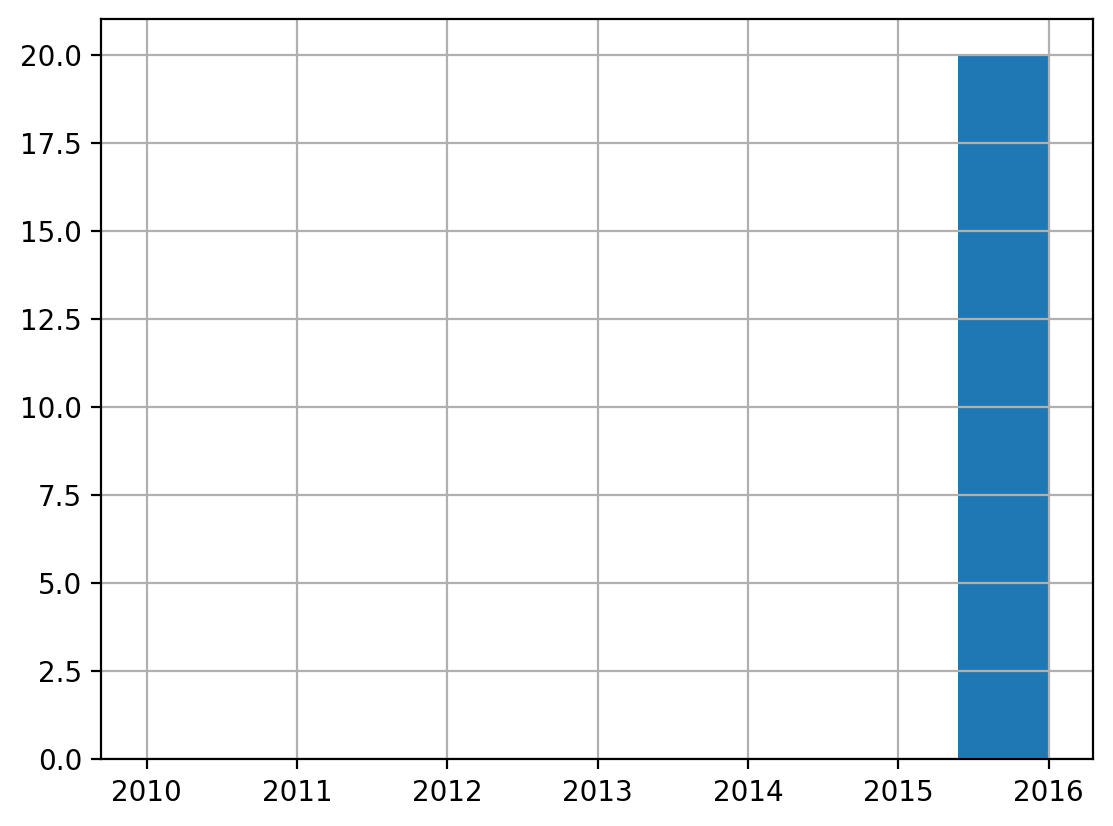

In [46]:
df.INSPECTION_DATE.hist(range=(pd.to_datetime('2010-01-01'),pd.to_datetime('2015-12-31')))

In [47]:
# Drop the 1900-01-01 inspections. These are all incorrect and we cannot fix them
df['TO_DELETE'] |= (df['INSPECTION_DATE'] == '1900-01-01')

In [48]:
# After analysis, it seems that we have minimal number of inspections before 2015
df['TO_DELETE'] |=  (df['INSPECTION_DATE'] < '2015-01-01')

In [49]:
sum(df['TO_DELETE'])

59090

### ACTION

In [50]:
sum(df.ACTION.isnull())

2205

In [51]:
df["ACTION"].value_counts()

Violations were cited in the following area(s).                                                                                       192575
Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.      7807
Establishment re-opened by DOHMH.                                                                                                       1857
No violations were recorded at the time of this inspection.                                                                             1139
Establishment re-closed by DOHMH.                                                                                                          4
Name: ACTION, dtype: int64

In [52]:
df["ACTION"].replace(
    to_replace='Violations were cited in the following area(s).',
    value = 'Violations found',
    inplace=True
)

In [53]:
df["ACTION"].replace(
    to_replace='No violations were recorded at the time of this inspection.',
    value = 'No violations',
    inplace=True
)

In [54]:
df["ACTION"].replace(
    to_replace='Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.',
    value = 'Establishment closed',
    inplace=True
)

In [55]:
df["ACTION"].replace(
    to_replace='Establishment re-opened by DOHMH.',
    value = 'Establishment re-opened',
    inplace=True
)

In [56]:
df["ACTION"].replace(
    to_replace='Establishment re-closed by DOHMH.',
    value = 'Establishment re-closed',
    inplace=True
)

In [57]:
df["ACTION"].value_counts()

Violations found           192575
Establishment closed         7807
Establishment re-opened      1857
No violations                1139
Establishment re-closed         4
Name: ACTION, dtype: int64

In [58]:
# Drop the Establishment re-opened and re-closed cases
# as the inspection scores for these can be misleading
df['TO_DELETE'] |=  (df.ACTION == 'Establishment re-closed')
df['TO_DELETE'] |=  (df.ACTION == 'Establishment re-opened')
df['TO_DELETE'] |=  df.ACTION.isnull()

In [59]:
sum(df['TO_DELETE'])

59090

### SCORE

In [60]:
df["SCORE"] = pd.to_numeric(df["SCORE"])

In [61]:
df.SCORE.describe()

count    196146.000000
mean         22.586461
std          17.431677
min           0.000000
25%          11.000000
50%          18.000000
75%          30.000000
max         168.000000
Name: SCORE, dtype: float64

In [62]:
len(df)

205587

In [63]:
len( df[ df.SCORE < 0 ] )

0

In [64]:
df['TO_DELETE'] |= (df.SCORE < 0)

In [65]:
sum(df['TO_DELETE'])

59090

In [66]:
# Drop cases reported as "no violations but with positive score"
df['TO_DELETE'] |= ((df.SCORE > 0)  & (df.ACTION == 'No violations'))

# Drop cases with zero score but with violations found
df['TO_DELETE'] |= ((df.SCORE == 0)  & (df.ACTION == 'Violations found'))

In [67]:
# Drop incorrectly scored inspections
df['TO_DELETE'] |=  (df.GRADE=='A') & (df.SCORE>13)

df['TO_DELETE'] |=  (df.GRADE=='B') & ( (df.SCORE<14) | (df.SCORE>27) )

# Drop incorrectly scored inspections
df['TO_DELETE'] |=  (df.GRADE=='C') & (df.SCORE<28)


In [68]:
sum(df['TO_DELETE'])

66166

### RECORD_DATE

In [69]:
df["RECORD_DATE"] = pd.to_datetime(df["RECORD_DATE"], format="%m/%d/%Y")

In [70]:
# Drop record date field, as it only contains a single value
df = df.drop( 'RECORD_DATE', axis = 'columns')

### GRADE

In [71]:
df.GRADE.value_counts()

A    70673
B    10820
N     9651
C     6260
Z     3778
P      570
Name: GRADE, dtype: int64

In [72]:
sum(df.GRADE.isnull())

103835

In [73]:
df.query(" GRADE == 'G' ")

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE_DESCRIPTION,INSPECTION_DATE,ACTION,...,INSPECTION_TYPE,LATITUDE,LONGITUDE,COMMUNITY_BOARD,COUNCIL_DISTRICT,CENSUS_TRACT,BIN,BBL,NTA,TO_DELETE


In [74]:
# Seems that all the "G" correspond to "A"
df.GRADE.replace('G', 'A', inplace=True)

In [75]:
# P assigned to 'Establishment re-opened' actions
df.query(" GRADE == 'P' ")

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE_DESCRIPTION,INSPECTION_DATE,ACTION,...,INSPECTION_TYPE,LATITUDE,LONGITUDE,COMMUNITY_BOARD,COUNCIL_DISTRICT,CENSUS_TRACT,BIN,BBL,NTA,TO_DELETE
201,50129154,Auntie Anne's / Cinnabon / Carvel,Bronx,1370,METROPOLITAN AVENUE,10462,9199037490,Bakery Products/Desserts,2022-12-14,Establishment re-opened,...,Pre-permit (Operational) / Reopening Inspection,40.834999593779,-73.861045522957,209,18,021200,2096674,2039387501,BX46,True
233,50119911,JUSTIN'S PIZZA,Bronx,840,RIVER AVENUE,10451,3472454836,Pizza,2022-04-18,Establishment re-opened,...,Pre-permit (Operational) / Reopening Inspection,40.826960327356,-73.926410163903,204,08,006300,2002979,2024830032,BX63,True
511,50099285,JELL & CHILL,Manhattan,110,EAST 7 STREET,10009,6463705229,Frozen Desserts,2019-12-16,Establishment re-opened,...,Pre-permit (Operational) / Reopening Inspection,40.726500172357,-73.984641175415,103,02,003200,1005784,1004340019,MN22,True
666,50122599,FARIDA,Manhattan,32,CEDAR STREET,10005,6466503272,Russian,2022-07-07,Establishment re-opened,...,Pre-permit (Operational) / Reopening Inspection,40.707147534413,-74.008371492287,101,01,000700,1001013,1000410024,MN25,True
1043,50117979,BARISTA & THE BAKER,Brooklyn,167,ROGERS AVENUE,11216,5164047009,Jewish/Kosher,2022-02-03,Establishment re-opened,...,Pre-permit (Operational) / Reopening Inspection,40.671648323028,-73.953103593308,308,35,031702,3032221,3012540011,BK61,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203476,50043260,THE DEAD POET,Manhattan,450,AMSTERDAM AVENUE,10024,2125955670,Irish,2019-08-08,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.784852500266,-73.977091354051,107,06,016700,1032685,1012290034,MN12,True
204091,50105575,COME ON THAI CUISINE,Brooklyn,7803,3 AVENUE,11209,3477411992,Thai,2021-11-09,Establishment re-opened,...,Pre-permit (Operational) / Reopening Inspection,40.629165122019,-74.028716456049,310,47,006400,3150286,3059690010,BK31,True
204745,50106213,ROYAL SEAFOOD CAFE,Manhattan,103,MOTT STREET,10013,2129667199,Chinese,2022-10-03,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.717311692095,-73.99746039087,102,01,004100,1082936,1002057501,MN24,True
204938,50034739,ELLINGTON IN THE PARK,Manhattan,W105,HUDSON BEACH,NaN,9176805280,American,2019-07-01,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,0,0,NaN,NaN,NaN,NaN,1,NaN,True


In [76]:
# P assigned to 'Establishment re-opened' actions
df.query(" GRADE == 'P' ").ACTION.value_counts()

Establishment re-opened    570
Name: ACTION, dtype: int64

In [77]:
# P assigned to 'Reopening Inspection' inspection types
df.query(" GRADE == 'P' ").INSPECTION_TYPE.value_counts()

Cycle Inspection / Reopening Inspection            386
Pre-permit (Operational) / Reopening Inspection    184
Name: INSPECTION_TYPE, dtype: int64

In [ ]:
# df.query(" GRADE == 'Z' ").SCORE.hist(bins=100)

In [78]:
# TODO: Figure out what Z, and Not Yet Graded means in GRADE
# Until then, we just replace these values with NULL, keeping only the A, B, C grades

#
df.GRADE.value_counts()

A    70673
B    10820
N     9651
C     6260
Z     3778
P      570
Name: GRADE, dtype: int64

In [79]:
df['TO_DELETE'] |=  (df.GRADE=='Z')
df['TO_DELETE'] |=  (df.GRADE=='P')
df['TO_DELETE'] |=  (df.GRADE=='N') # Not Yet Graded
df['TO_DELETE'] |=  (df.GRADE=='Not Yet Graded')

### GRADE_DATE

In [80]:
df["GRADE_DATE"] = pd.to_datetime(df["GRADE_DATE"], format="%m/%d/%Y")


In [81]:
# Grade date and inspection date should be the same.
assert np.abs((df.GRADE_DATE - df.INSPECTION_DATE).dropna()).sum().days == 0

In [82]:
# Check that is there is a grade date, a grade is also assigned
assert sum ( ~df.GRADE_DATE.isnull() & df.GRADE.isnull() )  == 0

In [ ]:
# We do not need GRADE DATE if we have INSPECTION DATE
df = df.drop("GRADE_DATE", axis='columns')

### VIOLATION_CODE and VIOLATION_DESCRIPTION

In [85]:
df.VIOLATION_CODE.isnull().sum()

3340

In [86]:
# All the cases where violation code is NULL should be either cases that we delete
# or a "No violations" case
check = df[df.VIOLATION_CODE.isnull() & ~df.TO_DELETE & (df.ACTION!='No violations')]

assert( len(check) == 0 )


In [87]:
df.VIOLATION_DESCRIPTION.isnull().sum()

3340

In [88]:
# Checks that all VIOLATION_CODE has unique VIOLATION_DESCRIPTION
df[['VIOLATION_CODE','VIOLATION_DESCRIPTION']].drop_duplicates().pivot_table(
    index='VIOLATION_CODE',
    values='VIOLATION_DESCRIPTION',
    aggfunc=pd.Series.nunique
).sort_values('VIOLATION_DESCRIPTION', ascending=False).head(20)

,VIOLATION_DESCRIPTION
VIOLATION_CODE,
06A,4
05C,4
06C,4
10G,3
05D,3
05B,3
04N,3
08C,3
09C,3


In [ ]:
df['TO_DELETE'] |=  (df.VIOLATION_DESCRIPTION == 'Caloric content not posted on menus, menu boards or food tags, in a food service establishment that is 1 of 15 or more outlets operating the same type of business nationally under common ownership or control, or as a franchise or doing business under the same name, for each menu item that is served in portions, the size and content of which are standardized.')

In [ ]:
# In the dataset we have a NULL violation, when there is no violation
# To make this more explicit, we replace NULL with 000
# df.VIOLATION_CODE.fillna('000', inplace=True)

In [89]:
df.VIOLATION_CODE.isnull().sum()

3340

In [ ]:
## LATITUDE and LONGITUDE

In [90]:
df['LONGITUDE'] = pd.to_numeric(df['LONGITUDE'])
df['LATITUDE'] = pd.to_numeric(df['LATITUDE'])

### MISC analysis

In [91]:
# Find the unique values in each column
#
# df.describe(include = [np.object, 'category']).T['unique']
unique = df.describe(include = 'all').T['unique'].sort_values()

for column in unique.index:
    if unique[column] < 200:
        print(df[column].value_counts())
        print("=====")

<ipython-input-91-c484cf3850a3>:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  unique = df.describe(include = 'all').T['unique'].sort_values()


False    134391
True      71196
Name: TO_DELETE, dtype: int64
=====
Critical          112205
Not Critical       88777
Not Applicable      4605
Name: CRITICAL_FLAG, dtype: int64
=====
Violations found           192575
Establishment closed         7807
Establishment re-opened      1857
No violations                1139
Establishment re-closed         4
Name: ACTION, dtype: int64
=====
Manhattan        76160
Brooklyn         54810
Queens           49213
Bronx            18469
Staten Island     6923
0                   12
Name: BORO, dtype: int64
=====
A    70673
B    10820
N     9651
C     6260
Z     3778
P      570
Name: GRADE, dtype: int64
=====
Initial Inspection                                             112967
Re-inspection                                                   36080
Pre-permit (Operational) / Initial Inspection                   30463
Pre-permit (Operational) / Re-inspection                         9085
Administrative Miscellaneous / Initial Inspection                47

In [92]:
df.dtypes

CAMIS                            object
DBA                              object
BORO                             object
BUILDING                         object
STREET                           object
ZIPCODE                          object
PHONE                            object
CUISINE_DESCRIPTION              object
INSPECTION_DATE          datetime64[ns]
ACTION                           object
VIOLATION_CODE                   object
VIOLATION_DESCRIPTION            object
CRITICAL_FLAG                    object
SCORE                           float64
GRADE                            object
INSPECTION_TYPE                  object
LATITUDE                        float64
LONGITUDE                       float64
COMMUNITY_BOARD                  object
COUNCIL_DISTRICT                 object
CENSUS_TRACT                     object
BIN                              object
BBL                              object
NTA                              object
TO_DELETE                          bool


## Deleting Entries

In this section, we use the results of the analysis above, and delete (additional) entries that will not be useful in our analysis. (Note that it is important to document this, as others may want to go back to the original source, if the entries that we leave are not sufficient.)

In [93]:
len(df)

205587

In [94]:
assert len(df) == initial_size

In [95]:
df = df[ df.TO_DELETE == False].copy()

In [96]:
len(df)

134391

In [97]:
df[df.VIOLATION_CODE.isnull()].VIOLATION_DESCRIPTION

24        NaN
133       NaN
282       NaN
541       NaN
605       NaN
         ... 
204214    NaN
204886    NaN
205115    NaN
205406    NaN
205488    NaN
Name: VIOLATION_DESCRIPTION, Length: 285, dtype: object

## Additional Data Quality Checks

In [98]:


assert sum(df.INSPECTION_TYPE.isnull()) == 0

assert len(set(df.INSPECTION_TYPE.values)) == 2

df["INSPECTION_TYPE"] =  pd.Categorical(df["INSPECTION_TYPE"], ordered=False)

In [99]:
# Check that no borough entries are empty
assert sum(df.BORO.isnull()) == 0

df["BORO"] =  pd.Categorical(df["BORO"], ordered=False)

In [100]:
# Check that no street numbers are empty
assert sum(df.BUILDING.isnull()) == 0

In [101]:
assert sum(df.STREET.isnull()) == 0

In [102]:

assert sum(df.CUISINE_DESCRIPTION.isnull()) == 0

df["CUISINE_DESCRIPTION"] =  pd.Categorical(df["CUISINE_DESCRIPTION"], ordered=False)

In [103]:
# We only keep three different actions
assert len(set(df.ACTION.values)) == 3

# No action is empty
assert sum(df.ACTION.isnull()) == 0

df["ACTION"] =  pd.Categorical(df["ACTION"], ordered=False)

In [104]:
# The below drops any grade values other than A, B, C, and converts the remaining entries to null
df["GRADE"] =  pd.Categorical(df["GRADE"], categories = ['A', 'B', 'C'], ordered=True)

# https://www1.nyc.gov/assets/doh/downloads/pdf/rii/how-we-score-grade.pdf
# 0-13 get an A
assert sum( (df.GRADE=='A') & (df.SCORE>13)) == 0

# 14-27 get a B
assert sum( (df.GRADE=='B') & ( (df.SCORE<14) | (df.SCORE>27) ) ) == 0

# 28- get a C
assert sum( (df.GRADE=='C') & (df.SCORE<28) ) == 0

# TODO: In principle, a NULL grade is only when the score is above 14, and it was an initial inspection

In [ ]:
# Check that is there is a grade date, a grade is also assigned
# assert sum ( ~df.GRADE_DATE.isnull() & df.GRADE.isnull() ) == 0

In [105]:
df["VIOLATION_CODE"] =  pd.Categorical(df["VIOLATION_CODE"], ordered=False)
df["CRITICAL_FLAG"] =  pd.Categorical(df["CRITICAL_FLAG"], ordered=False)


In [106]:
df [ df.VIOLATION_CODE.isnull() ].VIOLATION_DESCRIPTION

24        NaN
133       NaN
282       NaN
541       NaN
605       NaN
         ... 
204214    NaN
204886    NaN
205115    NaN
205406    NaN
205488    NaN
Name: VIOLATION_DESCRIPTION, Length: 285, dtype: object

## Normalization

### Violation Codes

In [107]:
# Recreating the table at https://www1.nyc.gov/assets/doh/downloads/pdf/rii/ri-violation-penalty.pdf

violation_codes = df [ ['VIOLATION_CODE', 'VIOLATION_DESCRIPTION', 'CRITICAL_FLAG'] ].drop_duplicates()
violation_codes = violation_codes.rename( {
    'VIOLATION_DESCRIPTION' : 'DESCRIPTION',
    'CRITICAL_FLAG' : 'CRITICAL'
},  axis = 'columns').sort_values('VIOLATION_CODE').dropna().set_index('VIOLATION_CODE')
violation_codes

,DESCRIPTION,CRITICAL
VIOLATION_CODE,,
02A,Time/Temperature Control for Safety (TCS) food...,Critical
02A,Food not cooked to required minimum temperature.,Critical
02A,Time/Temperature Control for Safety (TCS) food...,Critical
02B,Hot food item not held at or above 140º F.,Critical
02B,Hot TCS food item not held at or above 140 °F.,Critical
...,...,...
28-05,Food adulterated or misbranded. Adulterated o...,Not Critical
28-05,Food adulterated or misbranded. Adulterated or...,Not Critical
28-06,Contract with a pest management professional n...,Not Critical


In [108]:
violation_codes

,DESCRIPTION,CRITICAL
VIOLATION_CODE,,
02A,Time/Temperature Control for Safety (TCS) food...,Critical
02A,Food not cooked to required minimum temperature.,Critical
02A,Time/Temperature Control for Safety (TCS) food...,Critical
02B,Hot food item not held at or above 140º F.,Critical
02B,Hot TCS food item not held at or above 140 °F.,Critical
...,...,...
28-05,Food adulterated or misbranded. Adulterated o...,Not Critical
28-05,Food adulterated or misbranded. Adulterated or...,Not Critical
28-06,Contract with a pest management professional n...,Not Critical


In [109]:
# Drop the description and critical part from the main dataframe
df = df.drop(['VIOLATION_DESCRIPTION' ,  'CRITICAL_FLAG'], axis='columns')

In [110]:
df

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE_DESCRIPTION,INSPECTION_DATE,ACTION,...,INSPECTION_TYPE,LATITUDE,LONGITUDE,COMMUNITY_BOARD,COUNCIL_DISTRICT,CENSUS_TRACT,BIN,BBL,NTA,TO_DELETE
24,50048835,VIACOM CONFERENCE CENTER,Manhattan,1515,BROADWAY,10036,2128466633,Coffee/Tea,2023-06-30,No violations,...,Initial Inspection,40.757629,-73.985803,105,03,011900,1024714,1010160036,MN17,False
31,40384458,DREAM PIZZA,Queens,3767,JUNCTION BOULEVARD,11368,7189431599,Pizza,2022-03-08,Violations found,...,Initial Inspection,40.750340,-73.870112,403,21,037500,4043853,4017590035,QN26,False
33,41698540,LA 90 BAKERY,Queens,3706,90 STREET,11372,7184290690,Spanish,2022-04-21,Violations found,...,Initial Inspection,40.750114,-73.876811,403,21,027700,4036316,4014770001,QN28,False
52,41692932,GOURMET 45,Manhattan,721,3 AVENUE,10017,2126826220,Sandwiches,2020-02-12,Violations found,...,Initial Inspection,40.752776,-73.972966,106,04,009000,1037582,1013190001,MN19,False
54,50062554,LA CASA DEL POLLO AND PIZZA,Manhattan,4231,BROADWAY,10033,2127955500,Spanish,2022-08-11,Violations found,...,Initial Inspection,40.849262,-73.936716,112,10,026500,1064269,1021760050,MN36,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205577,50100383,CAFE 47,Manhattan,47,WEST 66 STREET,10023,2124562453,American,2022-06-17,Violations found,...,Initial Inspection,40.772987,-73.980081,107,06,015300,1081016,1011190021,MN14,False
205578,50057047,SODAM,Queens,15650,NORTHERN BLVD,11354,7188861616,Korean,2021-08-07,Violations found,...,Initial Inspection,40.763918,-73.808681,407,20,117100,4119330,4052750031,QN51,False
205579,50077362,FUSION FARE FOODS,Manhattan,2,WEST 45 STREET,10036,2122283445,American,2022-05-03,Violations found,...,Initial Inspection,40.755597,-73.979975,105,04,009600,1034228,1012600042,MN17,False
205580,40365942,HOP KEE RESTAURANT,Manhattan,21,MOTT STREET,10013,2129648365,Chinese,2023-08-24,Violations found,...,Initial Inspection,40.714364,-73.998784,103,01,002900,1001821,1001640045,MN27,False


### Restaurants

In [111]:
df.columns.values

array(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE_DESCRIPTION', 'INSPECTION_DATE', 'ACTION',
       'VIOLATION_CODE', 'SCORE', 'GRADE', 'INSPECTION_TYPE', 'LATITUDE',
       'LONGITUDE', 'COMMUNITY_BOARD', 'COUNCIL_DISTRICT', 'CENSUS_TRACT',
       'BIN', 'BBL', 'NTA', 'TO_DELETE'], dtype=object)

In [112]:
columns = ['CAMIS', 'DBA', 'BUILDING', 'STREET', 'ZIPCODE', 'BORO', 'PHONE',
           'CUISINE_DESCRIPTION', 'LATITUDE', 'LONGITUDE',
       'COMMUNITY_BOARD', 'COUNCIL_DISTRICT', 'CENSUS_TRACT', 'BIN',
       'BBL', 'NTA']
restaurants =  df [ columns ].drop_duplicates()

In [113]:
# Check that we have the same attributes for a given CAMIS
# and the we do not have duplicate CAMIS values
assert len(restaurants) == len(set(restaurants.CAMIS.values))

In [114]:
restaurants.head(5)

,CAMIS,DBA,BUILDING,STREET,ZIPCODE,BORO,PHONE,CUISINE_DESCRIPTION,LATITUDE,LONGITUDE,COMMUNITY_BOARD,COUNCIL_DISTRICT,CENSUS_TRACT,BIN,BBL,NTA
24,50048835,VIACOM CONFERENCE CENTER,1515,BROADWAY,10036,Manhattan,2128466633,Coffee/Tea,40.757629,-73.985803,105,03,011900,1024714,1010160036,MN17
31,40384458,DREAM PIZZA,3767,JUNCTION BOULEVARD,11368,Queens,7189431599,Pizza,40.750340,-73.870112,403,21,037500,4043853,4017590035,QN26
33,41698540,LA 90 BAKERY,3706,90 STREET,11372,Queens,7184290690,Spanish,40.750114,-73.876811,403,21,027700,4036316,4014770001,QN28
52,41692932,GOURMET 45,721,3 AVENUE,10017,Manhattan,2126826220,Sandwiches,40.752776,-73.972966,106,04,009000,1037582,1013190001,MN19
54,50062554,LA CASA DEL POLLO AND PIZZA,4231,BROADWAY,10033,Manhattan,2127955500,Spanish,40.849262,-73.936716,112,10,026500,1064269,1021760050,MN36


In [115]:
restaurants.PHONE.value_counts().head(20)

2124656273    43
9176186310    33
9172843260    29
2126159700    19
2125867610    17
7182153308    15
2125825472    14
2124656302    14
9177437388    10
7182246030    10
__________    10
6143187413    10
9178863304    10
2122441111     9
7186566210     9
2123959280     9
9177965620     8
2129818588     8
2125325003     8
7043285090     8
Name: PHONE, dtype: int64

In [ ]:
# __ = restaurants.PHONE.value_counts().head(10).index.values[7]

In [ ]:
# restaurants.PHONE.replace(to_replace=__, value=np.nan, inplace=True)

In [ ]:
# Citi Field concessions
# restaurants.query("PHONE == '7185958100'").head(5)

In [ ]:
# Madison Square Garden concession stands
# restaurants.query("PHONE == '2124656273'").head(5)

In [ ]:
# restaurants.plot(kind='scatter', x='LONGITUDE', y='LATITUDE', alpha=0.2, s=1, figsize=(15,15))

In [116]:
df = df.drop (columns[1:], axis='columns')

In [117]:
df

,CAMIS,INSPECTION_DATE,ACTION,VIOLATION_CODE,SCORE,GRADE,INSPECTION_TYPE,TO_DELETE
24,50048835,2023-06-30,No violations,NaN,0.0,A,Initial Inspection,False
31,40384458,2022-03-08,Violations found,02B,48.0,NaN,Initial Inspection,False
33,41698540,2022-04-21,Violations found,02B,12.0,A,Initial Inspection,False
52,41692932,2020-02-12,Violations found,09B,11.0,A,Initial Inspection,False
54,50062554,2022-08-11,Violations found,02B,12.0,A,Initial Inspection,False
...,...,...,...,...,...,...,...,...
205577,50100383,2022-06-17,Violations found,08A,13.0,A,Initial Inspection,False
205578,50057047,2021-08-07,Violations found,09B,12.0,A,Initial Inspection,False
205579,50077362,2022-05-03,Violations found,10B,58.0,NaN,Initial Inspection,False
205580,40365942,2023-08-24,Violations found,06D,34.0,NaN,Initial Inspection,False


### Inspections

In [118]:
# Each inspection has multiple violations. We want to keep just the inspections for now
inspection = df.drop('VIOLATION_CODE', axis='columns').drop_duplicates().sort_values(['INSPECTION_DATE', 'CAMIS'])

In [119]:
inspection

,CAMIS,INSPECTION_DATE,ACTION,SCORE,GRADE,INSPECTION_TYPE,TO_DELETE
36062,40944945,2015-10-14,Violations found,5.0,A,Re-inspection,False
44469,50015538,2015-11-19,Violations found,12.0,A,Initial Inspection,False
165587,50015171,2015-11-20,Violations found,10.0,A,Initial Inspection,False
11940,40560949,2015-12-01,Violations found,4.0,A,Initial Inspection,False
38399,41611709,2015-12-12,Violations found,21.0,NaN,Initial Inspection,False
...,...,...,...,...,...,...,...
135603,50108157,2023-09-15,Violations found,2.0,A,Re-inspection,False
96285,50117817,2023-09-15,Violations found,25.0,NaN,Initial Inspection,False
38461,50128264,2023-09-15,Violations found,5.0,A,Re-inspection,False
51746,50137234,2023-09-15,Violations found,11.0,A,Initial Inspection,False


In [120]:
# We create an ID for each inspection here
inspection = inspection.reset_index().drop('index', axis='columns').reset_index().rename({'index': 'INSPECTION_ID'}, axis='columns')

In [121]:
inspection.ACTION.value_counts()

Violations found        41947
Establishment closed      755
No violations             286
Name: ACTION, dtype: int64

In [122]:
# Ensure that the inspection table contains
# no duplicate pairs for 'INSPECTION_DATE', 'CAMIS'
pvt = inspection.pivot_table(
    index = ['INSPECTION_DATE', 'CAMIS'],
    values = 'INSPECTION_ID',
    aggfunc = 'count'
)
pvt [ pvt.INSPECTION_ID > 1 ]

# assert len(pvt [ pvt.INSPECTION_ID > 1 ]) == 0

,,INSPECTION_ID
INSPECTION_DATE,CAMIS,
2017-11-04,40911114,2


In [ ]:
# df[ (df.CAMIS =='41007054') & (df.INSPECTION_DATE == '2017-03-03')  ].sort_values('VIOLATION_CODE')

In [ ]:
# to_drop = inspection.query(" CAMIS =='50051092' and  INSPECTION_DATE == '2019-09-11' ").index.values[1]
# inspection = inspection.drop(to_drop, axis='index')

In [123]:
to_drop = inspection.query(" CAMIS =='40911114' and  INSPECTION_DATE == '2017-11-04' ").index.values[1]

inspection = inspection.drop(to_drop, axis='index')

In [124]:
inspection.drop('TO_DELETE', axis='columns', inplace=True)

In [125]:
# Ensure that the inspection table contains
# no duplicate pairs for 'INSPECTION_DATE', 'CAMIS'
pvt = inspection.pivot_table(
    index = ['INSPECTION_DATE', 'CAMIS'],
    values = 'INSPECTION_ID',
    aggfunc = 'count'
)
assert len(pvt [ pvt.INSPECTION_ID > 1 ]) == 0

In [126]:
inspection.INSPECTION_TYPE.value_counts()

Initial Inspection    32262
Re-inspection         10725
Name: INSPECTION_TYPE, dtype: int64

In [127]:
inspection_stats = inspection.pivot_table(
    index = 'CAMIS',
    aggfunc = ['min', 'max', 'count'],
    values = 'INSPECTION_DATE'
)

<Axes: xlabel='INSPECTION_DATE'>

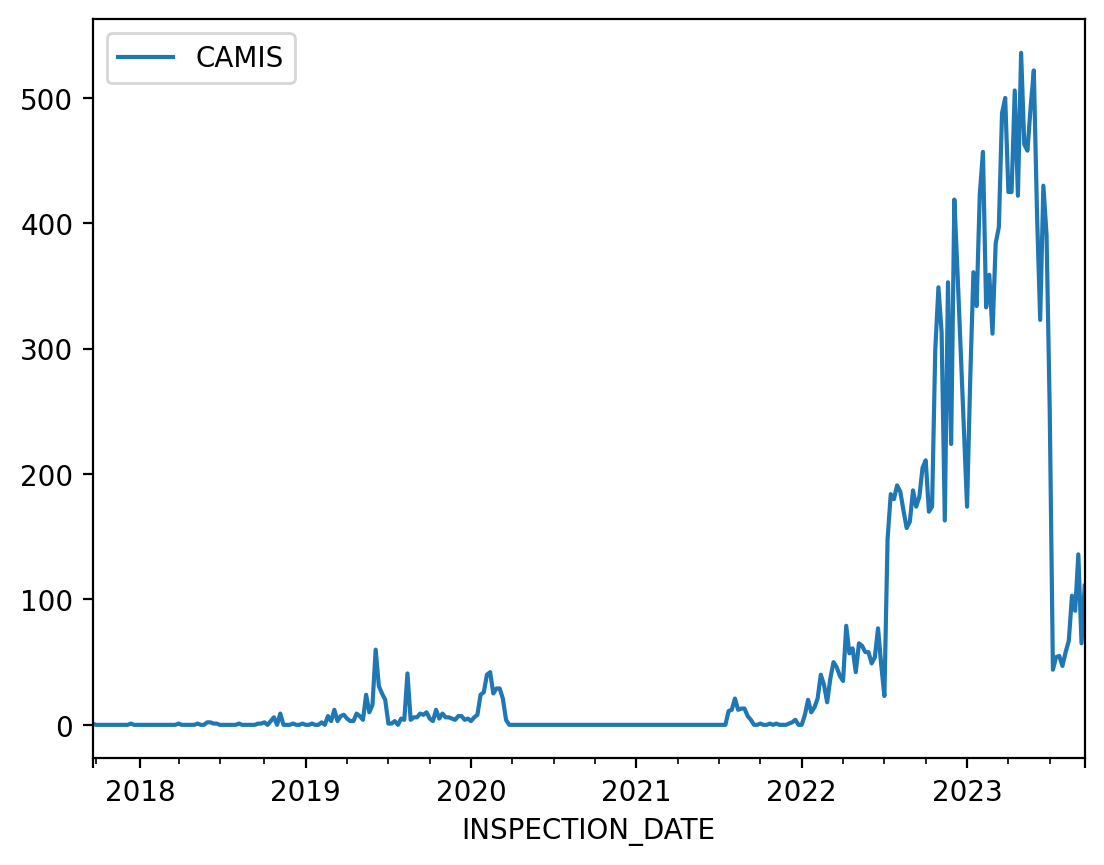

In [128]:
# Distribution of last inspection across all restaurants
inspection_stats['max'].sort_values('INSPECTION_DATE').reset_index().pivot_table(
    index='INSPECTION_DATE',
    aggfunc='count'
).resample('1W').sum().plot()

In [ ]:
# Longevity
# (inspection_stats['max'] - inspection_stats['min'])['INSPECTION DATE'].sort_values()

<Axes: >

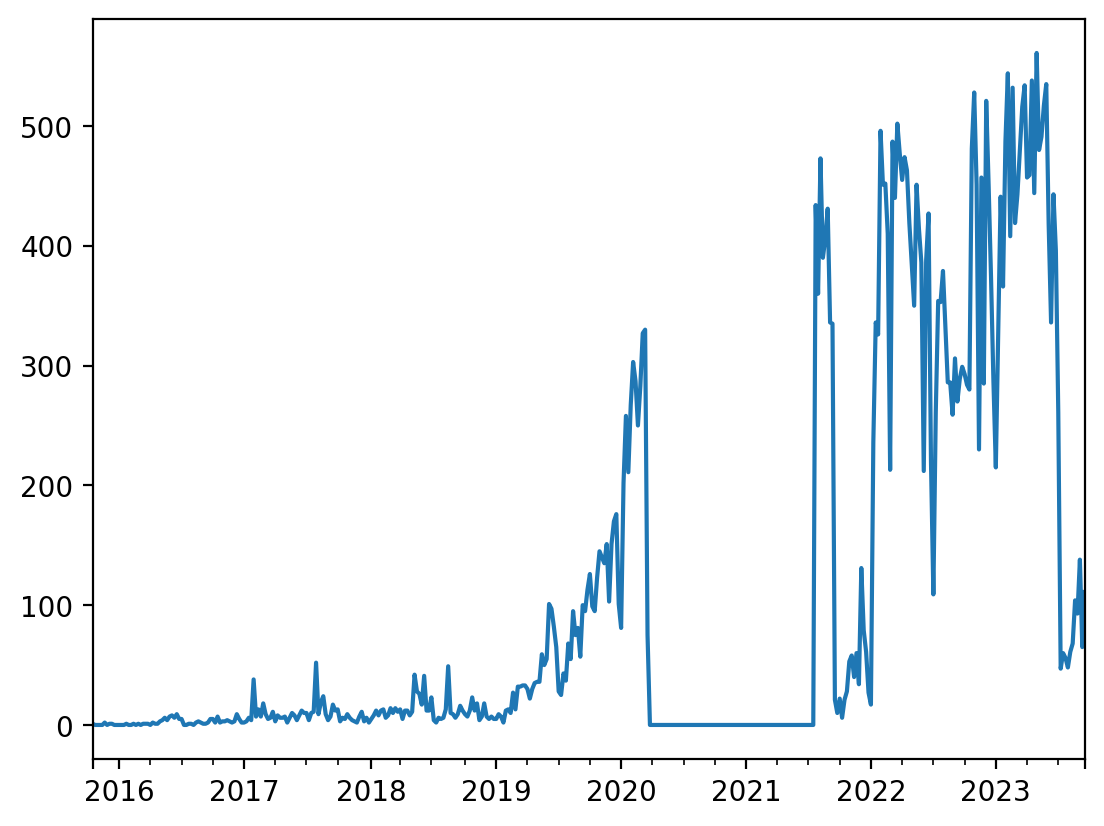

In [129]:
# Distribution of all inspections
inspection['INSPECTION_DATE'].value_counts().sort_index().resample('1W').sum().plot()

In [130]:
len(df)

134391

In [131]:
violations = pd.merge(
    inspection,
    df[ ['CAMIS', 'INSPECTION_DATE', 'VIOLATION_CODE' ] ],
    on= ['CAMIS', 'INSPECTION_DATE'],
    how = 'inner'
)
violations = violations[ ['INSPECTION_ID', 'VIOLATION_CODE'] ].drop_duplicates()
len(violations)

134387

In [132]:
print(f"Violations: {len(violations)}")
print(f"Inspections: {len(inspection)}")
print(f"Restaurants: {len(restaurants)}")
print(f"Violation Codes: {len(violation_codes)}")

Violations: 134387
Inspections: 42987
Restaurants: 19314
Violation Codes: 151


## Storing in MySQL


In [133]:
!sudo pip3 install -U -q PyMySQL sqlalchemy sql_magic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 98.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 12.3 MB/s eta 0:00:00


In [134]:
import os
from sqlalchemy import create_engine
from sqlalchemy import text

conn_string = 'mysql+pymysql://{user}:{password}@{host}/?charset=utf8mb4'.format(
    host = 'db.ipeirotis.org',
    user = 'root',
    password = 'ae6jQniBS5muV27', #os.environ['MYSQL_PASSWORD'],
    encoding = 'utf8mb4')

engine = create_engine(conn_string)
con = engine.connect()

In [142]:
# Query to create a database
db_name = 'doh_restaurants'

sql = f"DROP DATABASE IF EXISTS {db_name}"
with engine.connect() as connection:
  connection.execute(text(sql))

# Create a database
sql = f"CREATE DATABASE IF NOT EXISTS {db_name} DEFAULT CHARACTER SET 'utf8mb4'"
with engine.connect() as connection:
  connection.execute(text(sql))

# And lets switch to the database
sql = f"USE {db_name}"
with engine.connect() as connection:
  connection.execute(text(sql))

In [143]:
create_table_sql = '''
CREATE TABLE restaurants (
    CAMIS                      char(8),
    DBA varchar(90),
    BUILDING varchar(10),
    STREET varchar(40),
    ZIPCODE char(5),
    BORO ENUM('Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island')  ,
    PHONE char(10),
    CUISINE_DESCRIPTION    varchar(30),
LATITUDE                float,
LONGITUDE               float,
COMMUNITY_BOARD          char(3),
COUNCIL_DISTRICT         char(2),
CENSUS_TRACT             char(6),
BIN                      char(7),
BBL                      char(10),
NTA                      char(4),
PRIMARY KEY(CAMIS)
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
'''
with engine.connect() as connection:
  connection.execute(text(create_table_sql))


create_table_sql = '''
CREATE TABLE inspections (
    INSPECTION_ID               char(8),
    CAMIS                      char(8),
    INSPECTION_DATE    datetime,
    ACTION                   ENUM('Violations found','Establishment closed','No violations'),
    SCORE                     smallint,
    GRADE                    char(1),
    INSPECTION_TYPE          ENUM('Initial Inspection','Re-inspection'),
    FOREIGN KEY(CAMIS) REFERENCES restaurants(CAMIS),
    PRIMARY KEY(INSPECTION_ID)
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
'''
with engine.connect() as connection:
  connection.execute(text(create_table_sql))

create_table_sql = '''
CREATE TABLE violation_codes (
  VIOLATION_CODE     char(5),
  DESCRIPTION varchar(1000),
  CRITICAL ENUM('Critical', 'Not Applicable', 'Not Critical'),
  PRIMARY KEY(VIOLATION_CODE)

) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
'''
with engine.connect() as connection:
  connection.execute(text(create_table_sql))


create_table_sql = '''
CREATE TABLE violations (
  INSPECTION_ID         char(8),
  VIOLATION_CODE     char(5),
  FOREIGN KEY(INSPECTION_ID) REFERENCES inspections(INSPECTION_ID)
  -- FOREIGN KEY(VIOLATION_CODE) REFERENCES violation_codes(VIOLATION_CODE)
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
'''
with engine.connect() as connection:
  connection.execute(text(create_table_sql))

In [137]:
violation_codes.reset_index().VIOLATION_CODE.str.len().max()

5

In [138]:
violation_codes

,DESCRIPTION,CRITICAL
VIOLATION_CODE,,
02A,Time/Temperature Control for Safety (TCS) food...,Critical
02A,Food not cooked to required minimum temperature.,Critical
02A,Time/Temperature Control for Safety (TCS) food...,Critical
02B,Hot food item not held at or above 140º F.,Critical
02B,Hot TCS food item not held at or above 140 °F.,Critical
...,...,...
28-05,Food adulterated or misbranded. Adulterated o...,Not Critical
28-05,Food adulterated or misbranded. Adulterated or...,Not Critical
28-06,Contract with a pest management professional n...,Not Critical


In [144]:
violation_codes = violation_codes.groupby('VIOLATION_CODE').first()

In [145]:
violation_codes.reset_index().to_sql(
        name = 'violation_codes',
        schema = db_name,
        con = engine,
        if_exists = 'append',
        index = False,
        chunksize = 1000)

73

In [146]:
restaurants.to_sql(
        name = 'restaurants',
        schema = db_name,
        con = engine,
        if_exists = 'append',
        index = False,
        chunksize = 1000)

19314

In [147]:
inspection.to_sql(
        name = 'inspections',
        schema = db_name,
        con = engine,
        if_exists = 'append',
        index = False,
        chunksize = 1000)

42987

In [148]:
violations.to_sql(
        name = 'violations',
        schema = db_name,
        con = engine,
        if_exists = 'append',
        index = False,
        chunksize = 1000)

134387

In [149]:
sql = '''
GRANT SELECT ON doh_restaurants.* TO 'student'@'%'
'''
with engine.connect() as connection:
  connection.execute(text(sql))

In [150]:


sql = '''
CREATE VIEW restaurant_inspection_latest AS
	WITH latest_inspection AS (
		SELECT CAMIS, MAX(INSPECTION_DATE) AS INSPECTION_DATE FROM inspections
		GROUP BY CAMIS
	)
	SELECT R.CAMIS, R.DBA, R.BUILDING, R.STREET, R.ZIPCODE, R.BORO, R.CUISINE_DESCRIPTION, R.LATITUDE, R.LONGITUDE, I.INSPECTION_DATE, I.INSPECTION_ID, I.INSPECTION_TYPE, V.VIOLATION_CODE, I.SCORE, I.GRADE
		FROM restaurants R
			JOIN latest_inspection L ON R.CAMIS = L.CAMIS
			JOIN inspections I ON I.CAMIS = L.CAMIS AND L.INSPECTION_DATE = I.INSPECTION_DATE
			JOIN violations V ON I.INSPECTION_ID = V.INSPECTION_ID
      '''

with engine.connect() as connection:
  connection.execute(text(sql))